## 1.Define

#### Define the problam 

Customer syntement analysis based on amazon mobile review

In [ ]:
# os.environ["MODIN_ENGINE"] = "ray"
# import modin.pandas as pd

In [97]:
import nltk
import re
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup  
from string import punctuation
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
%matplotlib inline

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,confusion_matrix, roc_auc_score,f1_score,recall_score, precision_score,classification_report

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

## 2. Descover

#### Load the data

In [2]:
df = pd.read_csv("Amazon_Unlocked_Mobile.csv")

In [3]:
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


### EDA

In [4]:
df.isna().sum()

Product Name        0
Brand Name      65171
Price            5933
Rating              0
Reviews            62
Review Votes    12296
dtype: int64

In [5]:
df.shape

(413840, 6)

In [6]:
df.columns

Index(['Product Name', 'Brand Name', 'Price', 'Rating', 'Reviews',
       'Review Votes'],
      dtype='object')

In [7]:
df.Rating.unique()

array([5, 4, 1, 2, 3], dtype=int64)

In [8]:
df.Rating.value_counts()

5    223605
1     72350
4     61392
3     31765
2     24728
Name: Rating, dtype: int64

In [9]:
Brand_Name = df['Brand Name']
Brand_Name.value_counts().head(10)

Samsung       65747
BLU           63248
Apple         58186
LG            22417
BlackBerry    16872
Nokia         16806
Motorola      13417
HTC           12724
CNPGD         12613
OtterBox       7989
Name: Brand Name, dtype: int64

<AxesSubplot:>

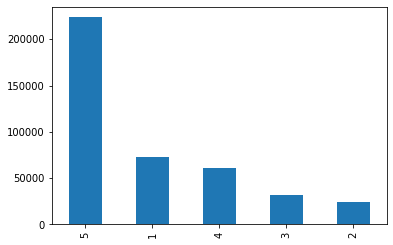

In [11]:
#Print the frequency of Rating in the sentiment column
fig, ax = plt.subplots()
df['Rating'].value_counts().plot(ax=ax, kind='bar')

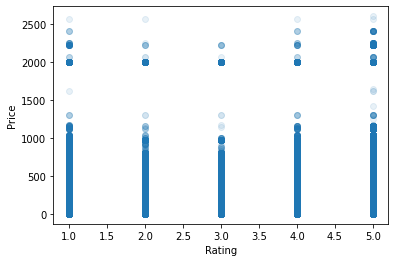

In [12]:
#Basic visualization of the dataset

ylabel = df["Price"]
plt.ylabel("Price")
plt.xlabel("Rating")
xlabel = df["Rating"]
plt.scatter(xlabel, ylabel, alpha=0.1)
plt.show()

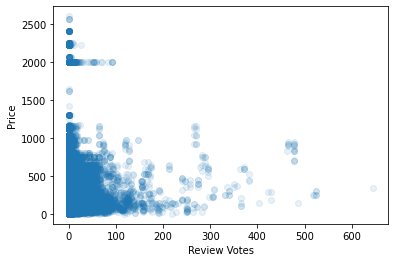

In [13]:
ylabel2 = df["Price"]
plt.ylabel("Price")
xlabel2 = df["Review Votes"]
plt.xlabel("Review Votes")
plt.scatter(xlabel2, ylabel2, alpha=0.1)
plt.show()

In [14]:
review = df.Reviews
len(review)

413840

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413840 entries, 0 to 413839
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Product Name  413840 non-null  object 
 1   Brand Name    348669 non-null  object 
 2   Price         407907 non-null  float64
 3   Rating        413840 non-null  int64  
 4   Reviews       413778 non-null  object 
 5   Review Votes  401544 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 18.9+ MB


In [16]:
df.isna().sum()

Product Name        0
Brand Name      65171
Price            5933
Rating              0
Reviews            62
Review Votes    12296
dtype: int64

### Plot number of reviews for top 20 brands

Total Brand:


384

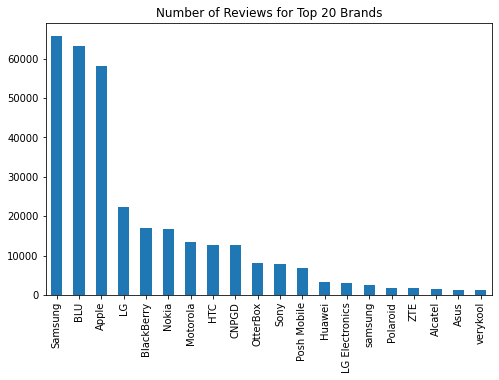

In [17]:
brands = df["Brand Name"].value_counts()
plt.figure(figsize=(8,5))
brands[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Brands")
print("Total Brand:")
brands.count()

#### removed neutral rating equals to 3

In [155]:
df=df[df['Rating']!=3]

In [156]:
#Encode 4 star and 5 star as positive rated 1.
#Encode 1 star and 2 star as Negative rated 0.
df['sentiment']=np.where(df['Rating'] > 3, 1, 0)

In [157]:
df = df.dropna()

In [158]:
df=df.reset_index(drop=True)

In [159]:
data = df

In [87]:
data= data.filter(['Reviews','Rating',"sentiment"],axis=1)
data.head()

,Reviews,Rating,sentiment
0,I feel so LUCKY to have found this used (phone...,5,1
1,"nice phone, nice up grade from my pantach revu...",4,1
2,Very pleased,5,1
3,It works good but it goes slow sometimes but i...,4,1
4,Great phone to replace my lost phone. The only...,4,1


In [25]:
data.shape

(308277, 3)

In [26]:
data.sentiment.value_counts()

1    230674
0     77603
Name: sentiment, dtype: int64

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308277 entries, 0 to 308276
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Reviews    308277 non-null  object
 1   Rating     308277 non-null  int64 
 2   sentiment  308277 non-null  int32 
dtypes: int32(1), int64(1), object(1)
memory usage: 5.9+ MB


### Data cleaning 

In [160]:
Cstopwords=set(stopwords.words('english')+list(punctuation))
from nltk.stem import WordNetLemmatizer
lemma=WordNetLemmatizer()
def clean_review(review_column):
    corpus=[]
    for i in range(0,len(review_column)):
        review=review_column[i]
        review = BeautifulSoup(review).get_text()
        review=re.sub('[^a-zA-Z]',' ',review)
        review=str(review).lower()
        review=word_tokenize(review)
        #review=[stemmer.stem(w) for w in review if w not in Cstopwords]
        review=[lemma.lemmatize(w) for w in review ]
        review=' '.join(review)
        corpus.append(review)
    return corpus

In [70]:
review_column=data['Reviews']

In [71]:
corpus =clean_review(review_column)
data['clean_review']=corpus

In [72]:
data.clean_review

0         i feel so lucky to have found this used phone ...
1         nice phone nice up grade from my pantach revue...
2                                              very pleased
3         it work good but it go slow sometimes but it a...
4         great phone to replace my lost phone the only ...
                                ...                        
308272    good rugged phone that ha a long lasting batte...
308273                                            used hard
308274                       another great deal great price
308275             pass every drop test onto porcelain tile
308276    only downside is that apparently verizon no lo...
Name: clean_review, Length: 308277, dtype: object

### Bag of words model

#### CountVectorizer

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_features=20000,min_df=5,ngram_range=(1,2))

In [74]:
X1=cv.fit_transform(data['clean_review'])
X1.shape

(308277, 20000)

#### TF-IDF

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(min_df=5, max_df=0.95, max_features = 20000, ngram_range = ( 1, 2 ),sublinear_tf = True)

In [76]:
tfidf=tfidf.fit(data['clean_review'])

In [77]:
X2=tfidf.transform(data['clean_review'])
X2.shape

(308277, 20000)

#### Define X and y

In [106]:
X=X2
X.shape

(308277, 20000)

In [107]:
y=df['sentiment'].values

In [108]:
y.shape

(308277,)

In [109]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(246621, 20000) (246621,)
(61656, 20000) (61656,)


In [110]:
print('mean positive review in train : {0:.3f}'.format(np.mean(y_train)))
print('mean positive review in test : {0:.3f}'.format(np.mean(y_test)))

mean positive review in train : 0.749
mean positive review in test : 0.747


### Linear Regression

In [84]:
# Let's create a function to create adjusted R-Squared
def adj_r2(x,y):
    r2 = model_Reg.score(x,y)
    n = x.shape[0]
    p = x.shape[1]
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    return adjusted_r2

In [85]:
%%time
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV, LassoCV, ElasticNet, ElasticNetCV
model_Reg=LinearRegression()
model_Reg.fit(X_train,y_train)

Wall time: 6min 45s


LinearRegression()

In [45]:
model_Reg.score(X_train,y_train)

0.813154062981564

In [46]:
adj_r2(X_train,y_train)

0.7966642618149913

Our r2 score is 81.13% and adj r2 is 79.66% for our training et., so looks like we are not being penalized by use of any feature.

Let's check how well model fits the test data.

Now let's check if our model is overfitting our data using regularization.

In [49]:
model_Reg.score(X_test,y_test)

0.7608636719871489

In [92]:
adj_r2(X_test,y_test)

0.6460460856167967

So it looks like our model r2 score is less on the test data.

Let's see if our model is overfitting our training data.

In [51]:
# Lasso Regularization
# LassoCV will return best alpha and coefficients after performing 10 cross validations
# lasscv = LassoCV(alphas = None,cv =10, max_iter = 100000, normalize = True)
# lasscv.fit(X_train, y_train)

In [52]:
# # best alpha parameter
# alpha = lasscv.alpha_
# alpha

In [53]:
# lasso_reg = Lasso(alpha)
# lasso_reg.fit(X_train, y_train)

In [54]:
# lasso_reg.score(X_test, y_test)

In [55]:
# # Using Ridge regression model
# # RidgeCV will return best alpha and coefficients after performing 10 cross validations. 
# # We will pass an array of random numbers for ridgeCV to select best alpha from them

# alphas = np.random.uniform(low=0, high=10, size=(50,))
# ridgecv = RidgeCV(alphas = alphas,cv=10,normalize = True)
# ridgecv.fit(X_train, y_train)

In [56]:
# ridgecv.alpha_

In [57]:
# ridge_model = Ridge(alpha=ridgecv.alpha_)
# ridge_model.fit(X_train, y_train)

In [58]:
# ridge_model.score(X_test, y_test)

In [59]:
# # Elastic net

# elasticCV = ElasticNetCV(alphas = None, cv =10)

# elasticCV.fit(X_train, y_train)

In [60]:
# elasticCV.alpha_

In [61]:
# # l1_ration gives how close the model is to L1 regularization, below value indicates we are giving equal
# #preference to L1 and L2
# elasticCV.l1_ratio

In [62]:
# elasticnet_reg = ElasticNet(alpha = elasticCV.alpha_,l1_ratio=0.5)
# elasticnet_reg.fit(X_train, y_train)

In [63]:
# elasticnet_reg.score(X_test, y_test)

###  Logistic Regression

In [113]:
from sklearn.linear_model import LogisticRegression
model_lr=LogisticRegression(random_state=0)

In [117]:
model_lr.fit(X_train,y_train)
y_pred_lr=model_lr.predict(X_test)

In [127]:
print('accuracy for Logistic Regression :',accuracy_score(y_test,y_pred_lr))
print('confusion matrix for Logistic Regression:\n',confusion_matrix(y_test,y_pred_lr))
print('classification_report:',classification_report(y_test,y_pred_lr))
print('F1 score for Logistic Regression :',f1_score(y_test,y_pred_lr))
print('Precision score for Logistic Regression :',precision_score(y_test,y_pred_lr))
print('recall score for Logistic Regression :',recall_score(y_test,y_pred_lr))
print('AUC: ', roc_auc_score(y_test, y_pred_lr))
score_lr = metrics.accuracy_score(y_test, y_pred_lr)
print("accuracy:   %0.3f" % score_lr)

accuracy for Logistic Regression : 0.9604255871285844
confusion matrix for Logistic Regression:
 [[14159  1439]
 [ 1001 45057]]
classification_report:               precision    recall  f1-score   support

           0       0.93      0.91      0.92     15598
           1       0.97      0.98      0.97     46058

    accuracy                           0.96     61656
   macro avg       0.95      0.94      0.95     61656
weighted avg       0.96      0.96      0.96     61656

F1 score for Logistic Regression : 0.9736370119065627
Precision score for Logistic Regression : 0.9690511011699932
recall score for Logistic Regression : 0.9782665335012376
AUC:  0.9430055580700186
accuracy:   0.960


In [130]:
# get the feature names as numpy array
feature_names = np.array(cv.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model_lr.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients

print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['not' 'worst' 'disappointed' 'poor' 'terrible' 'doesn' 'not happy'
 'horrible' 'return' 'useless']

Largest Coefs: 
['great' 'love' 'perfect' 'excellent' 'no problem' 'amazing' 'not bad'
 'awesome' 'best' 'love this']


### DecisionTree

In [133]:
from sklearn.tree import DecisionTreeClassifier
model_clf =DecisionTreeClassifier()
model_clf.fit(X_train,y_train)


DecisionTreeClassifier()

In [140]:
%%time
y_pred_dt=model_clf.predict(X_test)

Wall time: 81 ms


In [141]:
print('Accuracy forDecisionTree Classifier :',accuracy_score(y_test,y_pred_dt))
print('Confusion matrix for DecisionTree Classifier:\n',confusion_matrix(y_test,y_pred_dt))
print('F1 score for DecisionTree :',f1_score(y_test,y_pred_dt))
print('Precision score for DecisionTree :',precision_score(y_test,y_pred_dt))
print('Recall score for DecisionTree :',recall_score(y_test,y_pred_dt))
print('AUC: ', roc_auc_score(y_test, y_pred_dt))
score_dt = metrics.accuracy_score(y_test, y_pred_dt)
print("Accuracy:   %0.3f" % score_dt)

Accuracy forDecisionTree Classifier : 0.9536622550927728
Confusion matrix for DecisionTree Classifier:
 [[14107  1491]
 [ 1366 44692]]
F1 score for DecisionTree : 0.9690267885213733
Precision score for DecisionTree : 0.9677153931100189
Recall score for DecisionTree : 0.9703417430196708
AUC:  0.9373762824599572
Accuracy:   0.954


In [142]:
# get the feature names as numpy array
feature_names = np.array(cv.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model_clf.feature_importances_.argsort()

# Find the 10 smallest and 10 largest coefficients

print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['ability' 'pictured' 'pido' 'pin' 'pinch' 'pink color' 'pissed'
 'pixel density' 'pixelated' 'place and']

Largest Coefs: 
['not' 'great' 'love' 'return' 'after' 'good' 'the' 'price' 'excellent'
 'best']


### Naive Bayes Classifier

#### MultinomialNB

In [143]:
from sklearn.naive_bayes import MultinomialNB
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)
pred_nb = model_nb.predict(X_test)
score = metrics.accuracy_score(y_test, pred_nb)
print(classification_report(y_test,pred_nb))
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           0       0.89      0.86      0.87     15598
           1       0.95      0.97      0.96     46058

    accuracy                           0.94     61656
   macro avg       0.92      0.91      0.92     61656
weighted avg       0.94      0.94      0.94     61656

accuracy:   0.938


In [144]:
# get the feature names as numpy array
feature_names = np.array(cv.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model_nb.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients

print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['royalty to' 'worst purchase' 'total waste' 'started freezing'
 'reported stolen' 'wasted my' 'is scam' 'defectuoso' 'so mad' 'royalty']

Largest Coefs: 
['good' 'great' 'phone' 'it' 'excellent' 'the' 'and' 'love' 'very'
 'excelente']


#### Multinomial Classifier with Hyperparameter

In [154]:
model_nb=MultinomialNB(alpha=0.1)

previous_score=0
for alpha in np.arange(0,1,0.1):
    sub_classifier=MultinomialNB(alpha=alpha)
    sub_classifier.fit(X_train, y_train)
    y_pred=sub_classifier.predict(X_test)
    score = metrics.accuracy_score(y_test,y_pred)
    if score>previous_score:
        classifier=sub_classifier
    print("Alpha: {}, Score : {}".format(alpha,score))

Alpha: 0.0, Score : 0.9390813546126897
Alpha: 0.1, Score : 0.9388542883093292
Alpha: 0.2, Score : 0.9388867263526665
Alpha: 0.30000000000000004, Score : 0.9387083171143117
Alpha: 0.4, Score : 0.9384650317892824
Alpha: 0.5, Score : 0.9383839366809394
Alpha: 0.6000000000000001, Score : 0.9381406513559102
Alpha: 0.7000000000000001, Score : 0.9380595562475671
Alpha: 0.8, Score : 0.9378324899442065
Alpha: 0.9, Score : 0.9378000519008693


### Random Forest

In [147]:
from sklearn.ensemble import RandomForestClassifier

In [151]:
%%time
model_rf=RandomForestClassifier()
model_rf.fit(X_train,y_train)
y_pred_rf=model_rf.predict(X_test) 

Wall time: 21min 43s


In [152]:
print('Accuracy for Random Forest Classifier :',accuracy_score(y_test,y_pred_rf))
print('Confusion matrix for Random Forest Classifier:\n',confusion_matrix(y_test,y_pred_rf))
print('F1 score for Random Forest :',f1_score(y_test,y_pred_rf))
print('Precision score for Random Forest :',precision_score(y_test,y_pred_rf))
print('Recall score for Random Forest :',recall_score(y_test,y_pred_rf))
print('AUC: ', roc_auc_score(y_test, y_pred_rf))
score_rf = metrics.accuracy_score(y_test, y_pred_rf)
print("Accuracy:   %0.3f" % score_rf)

Accuracy for Random Forest Classifier : 0.9728817957700792
Confusion matrix for Random Forest Classifier:
 [[14428  1170]
 [  502 45556]]
F1 score for Random Forest : 0.98197965166408
Precision score for Random Forest : 0.9749604074819158
Recall score for Random Forest : 0.9891006991185027
AUC:  0.9570455412504939
Accuracy:   0.973


In [153]:
# get the feature names as numpy array
feature_names = np.array(cv.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model_rf.feature_importances_.argsort()

# Find the 10 smallest and 10 largest coefficients

print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['color gamut' 'royalty' 'io is' 'is responsive' 'the xl' 'sd storage'
 'saturated' 'royalty to' 'safari' 'juning']

Largest Coefs: 
['not' 'great' 'love' 'the' 'bad' 'good' 'return' 'after' 'the phone' 'to']
